<a id="section_toc"></a> 
## Tabla de Contenidos

<a href="#section_intro">Introducción - Importaciones</a>

<a href="#section_analisis">Analisis Inicial de  Columnas</a>

<a href="#section_visual">Visualizacion relaciones</a>

<a href="#section_regarg">Regresión lineal Argentina - SciKit Learn</a>

<a href="#section_regcaba">Regresión lineal CABA - SciKit Learn</a>

<a href="#section_stats">Regresión lineal - StatsModel</a>

<a href="#section_regu">Regularización Ridge y Lasso</a>

<a href="#section_muestra">Analisis de muestra de 100 propiedades</a>

---

<a id="section_intro"></a>

### Introducción - Importaciones

[volver a TOC](#section_toc)


In [1]:
#Importamos las librerías a utilizar
import pandas as pd
import numpy as np
import re
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn import metrics

import statsmodels.api as sm
from statsmodels.tools import eval_measures


In [2]:
#Traemos la base de datos a utilizar
data = pd.read_csv('./data/properati-subtes.csv', sep=',') # Para todo el país
data2 = pd.read_csv('./data/properati-subtes.csv', sep=',') # Para analizar solo CABA
data.head(5)

,Tipo_Propiedad,Región,Precio,surface_total_in_m2,surface_covered_in_m2,Precio_por_m2,Garage,Estado,Pileta,Balcon,Gimnasio,Quincho,Parrilla,Patio,Lavadero,Amenities,Ambientes,Barrio,dist_subte
0,PH,Capital Federal,62000.0,55.0,40.0,1550.000000,0,0,0,0,0,0,0,0,0,0,NaN,Mataderos,4.781915
1,apartment,Capital Federal,72000.0,55.0,55.0,1309.090909,0,0,0,0,0,0,0,0,0,0,NaN,Mataderos,5.436760
2,apartment,Buenos Aires Costa Atlántica,64000.0,35.0,35.0,1828.571429,0,0,0,0,0,0,0,0,0,0,NaN,Centro,0.000000
3,PH,Bs.As. G.B.A. Zona Norte,130000.0,106.0,78.0,1666.666667,0,0,0,0,0,0,0,0,0,0,NaN,Munro,0.000000
4,apartment,Capital Federal,138000.0,45.0,40.0,3450.000000,0,0,0,0,0,0,0,0,0,0,NaN,Belgrano,1.068329


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82112 entries, 0 to 82111
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tipo_Propiedad         82112 non-null  object 
 1   Región                 82112 non-null  object 
 2   Precio                 82112 non-null  float64
 3   surface_total_in_m2    82112 non-null  float64
 4   surface_covered_in_m2  82112 non-null  float64
 5   Precio_por_m2          82112 non-null  float64
 6   Garage                 82112 non-null  int64  
 7   Estado                 82112 non-null  int64  
 8   Pileta                 82112 non-null  int64  
 9   Balcon                 82112 non-null  int64  
 10  Gimnasio               82112 non-null  int64  
 11  Quincho                82112 non-null  int64  
 12  Parrilla               82112 non-null  int64  
 13  Patio                  82112 non-null  int64  
 14  Lavadero               82112 non-null  int64  
 15  Am

<a id="section_analisis"></a>

### Analisis Inicial de  Columnas

[volver a TOC](#section_toc)


In [4]:
# Tipo_Propiedad: Variable Categórica. No tenemos nulos, puede tener 4 valores posibles.
data.Tipo_Propiedad.value_counts()

apartment    48803
house        26890
PH            4227
store         2192
Name: Tipo_Propiedad, dtype: int64

In [5]:
# Creamos dummies
Tipo_Propiedad_dummy = pd.get_dummies(data['Tipo_Propiedad'], prefix= 'Tipo_Propiedad', drop_first=True)
data = pd.concat([data, Tipo_Propiedad_dummy], axis=1)

In [6]:
#Vemos resultado de Dummies. Vemos que agregó 3 columnas, OK.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82112 entries, 0 to 82111
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tipo_Propiedad            82112 non-null  object 
 1   Región                    82112 non-null  object 
 2   Precio                    82112 non-null  float64
 3   surface_total_in_m2       82112 non-null  float64
 4   surface_covered_in_m2     82112 non-null  float64
 5   Precio_por_m2             82112 non-null  float64
 6   Garage                    82112 non-null  int64  
 7   Estado                    82112 non-null  int64  
 8   Pileta                    82112 non-null  int64  
 9   Balcon                    82112 non-null  int64  
 10  Gimnasio                  82112 non-null  int64  
 11  Quincho                   82112 non-null  int64  
 12  Parrilla                  82112 non-null  int64  
 13  Patio                     82112 non-null  int64  
 14  Lavade

In [7]:
# Barrio: Variable Categórica. No tenemos nulos. Al tomar todo Argentina, puede tener 878 valores distintos.
# La utilizaremos al hacer foco en alguna región
data.Barrio.value_counts()

Mar del Plata             4990
Córdoba                   4513
Rosario                   4047
Tigre                     2914
Palermo                   2710
                          ... 
Apóstoles                    1
Balneario San Cayetano       1
El Calafate                  1
Uspallata                    1
Grand Bell                   1
Name: Barrio, Length: 864, dtype: int64

In [8]:
# Región: Variable Categórica. No tenemos nulos. Al tomar todo Argentina, puede tener 28 valores distintos.
data.Región.value_counts()

Capital Federal                 23422
Bs.As. G.B.A. Zona Norte        20883
Bs.As. G.B.A. Zona Sur           9320
Buenos Aires Costa Atlántica     7624
Bs.As. G.B.A. Zona Oeste         6887
Córdoba                          6002
Santa Fe                         4526
Buenos Aires Interior            1340
Corrientes                        422
Mendoza                           364
Río Negro                         268
Neuquén                           235
Misiones                          176
San Luis                          142
Tucumán                           128
Chubut                            124
Entre Ríos                         81
Salta                              63
Tierra Del Fuego                   27
Chaco                              26
La Pampa                           16
Catamarca                          15
Santa Cruz                          8
San Juan                            4
Formosa                             4
Jujuy                               3
Santiago Del

In [9]:
Region_dummy = pd.get_dummies(data['Región'], drop_first=True)
data = pd.concat([data, Region_dummy], axis=1)

In [10]:
#Vemos resultado de Dummies. Eran 28 Regiones y creó 27 Dummies.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82112 entries, 0 to 82111
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Tipo_Propiedad                82112 non-null  object 
 1   Región                        82112 non-null  object 
 2   Precio                        82112 non-null  float64
 3   surface_total_in_m2           82112 non-null  float64
 4   surface_covered_in_m2         82112 non-null  float64
 5   Precio_por_m2                 82112 non-null  float64
 6   Garage                        82112 non-null  int64  
 7   Estado                        82112 non-null  int64  
 8   Pileta                        82112 non-null  int64  
 9   Balcon                        82112 non-null  int64  
 10  Gimnasio                      82112 non-null  int64  
 11  Quincho                       82112 non-null  int64  
 12  Parrilla                      82112 non-null  int64  
 13  P

In [11]:
# Precio: Variable Cuantitativa. No tenemos nulos. Podemos ver las principales variables.
data.Precio.describe().round(2)

count      82112.00
mean      203825.76
std       189665.87
min         8412.55
25%        90000.00
50%       143509.06
75%       250000.00
max      4600000.00
Name: Precio, dtype: float64

In [12]:
# surface_total_in_m2: Variable Cuantitativa. No tenemos nulos. Podemos ver las principales variables.
# no lo estandarizamos ahora, sino que lo haremos luego de separar Train/Test.
a = data.surface_total_in_m2.describe().round(2)
print(a)


count    82112.00
mean       166.97
std        300.75
min         11.00
25%         50.00
50%         81.00
75%        182.00
max       9900.00
Name: surface_total_in_m2, dtype: float64


In [13]:
# surface_covered_in_m2: Variable Cuantitativa. No tenemos nulos. Podemos ver las principales variables.
# no lo estandarizamos ahora, sino que lo haremos luego de separar Train/Test.
a = data.surface_covered_in_m2.describe().round(2)

print(a)

count    82112.00
mean       115.39
std        113.07
min         11.00
25%         46.00
50%         74.00
75%        150.00
max       1940.00
Name: surface_covered_in_m2, dtype: float64


In [14]:
# Precio_por_m2: Es el precio sobre superficie cubierta.
# Variable Cuantitativa. No tenemos nulos. Podemos ver las principales variables. Esta será nuestra variable TARGET.
data.Precio_por_m2.describe().round(2)

count    82112.00
mean      2010.49
std        813.45
min        509.09
25%       1400.00
50%       1892.03
75%       2500.00
max       4497.23
Name: Precio_por_m2, dtype: float64

In [15]:
# Garage: Variable Categórica. No tenemos nulos. Puede tener 2 valores solamente. No necesitamos converirla a Dummies.
data.Garage.value_counts()

0    63197
1    18915
Name: Garage, dtype: int64

In [16]:
# Estado: Variable Categórica. No tenemos nulos. Puede tener 2 valores solamente. No necesitamos converirla a Dummies.
data.Estado.value_counts()

0    77776
1     4336
Name: Estado, dtype: int64

In [17]:
# Pileta: Variable Categórica. No tenemos nulos. Puede tener 2 valores solamente. No necesitamos converirla a Dummies.
data.Pileta.value_counts()

0    68643
1    13469
Name: Pileta, dtype: int64

In [18]:
# Balcon: Variable Categórica. No tenemos nulos. Puede tener 2 valores solamente. No necesitamos converirla a Dummies.
data.Balcon.value_counts()

0    60762
1    21350
Name: Balcon, dtype: int64

In [19]:
# Gimnasio: Variable Categórica. No tenemos nulos. Puede tener 2 valores solamente. No necesitamos converirla a Dummies.
data.Gimnasio.value_counts()

0    78953
1     3159
Name: Gimnasio, dtype: int64

In [20]:
# Quincho: Variable Categórica. No tenemos nulos. Puede tener 2 valores solamente. No necesitamos converirla a Dummies.
data.Quincho.value_counts()

0    76774
1     5338
Name: Quincho, dtype: int64

In [21]:
# Parrilla: Variable Categórica. No tenemos nulos. Puede tener 2 valores solamente. No necesitamos converirla a Dummies.
data.Parrilla.value_counts()

0    62040
1    20072
Name: Parrilla, dtype: int64

In [22]:
# Patio: Variable Categórica. No tenemos nulos. Puede tener 2 valores solamente. No necesitamos converirla a Dummies.
data.Patio.value_counts()

0    65343
1    16769
Name: Patio, dtype: int64

In [23]:
# Lavadero: Variable Categórica. No tenemos nulos. Puede tener 2 valores solamente. No necesitamos converirla a Dummies.
data.Lavadero.value_counts()

0    63312
1    18800
Name: Lavadero, dtype: int64

In [24]:
# Amenities: Suma la cantidad de ambientes. No tenemos nulos. Puede tener 7 valores distintos.
data.Amenities.value_counts()

0    33575
1    20285
2    14173
3     8142
4     4101
5     1545
6      266
7       25
Name: Amenities, dtype: int64

In [25]:
# Ambientes: Variable Categórica. Tiene muchos nulos, por lo que preferimos no inferirla
# Probaremos la regresión con y sin esta variable.
data.Ambientes.value_counts()

2.0     9375
3.0     9140
4.0     5102
1.0     1633
5.0     1379
6.0      409
7.0      159
8.0       27
9.0       17
10.0       8
Name: Ambientes, dtype: int64

In [26]:
Ambientes_dummy = pd.get_dummies(data['Ambientes'], drop_first=True)
data = pd.concat([data, Ambientes_dummy], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82112 entries, 0 to 82111
Data columns (total 58 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Tipo_Propiedad                82112 non-null  object 
 1   Región                        82112 non-null  object 
 2   Precio                        82112 non-null  float64
 3   surface_total_in_m2           82112 non-null  float64
 4   surface_covered_in_m2         82112 non-null  float64
 5   Precio_por_m2                 82112 non-null  float64
 6   Garage                        82112 non-null  int64  
 7   Estado                        82112 non-null  int64  
 8   Pileta                        82112 non-null  int64  
 9   Balcon                        82112 non-null  int64  
 10  Gimnasio                      82112 non-null  int64  
 11  Quincho                       82112 non-null  int64  
 12  Parrilla                      82112 non-null  int64  
 13  P

In [27]:
# dist_subte: SOLO PARA CABA. Variable Cuantitativa. En CABA tenemos 5006 nulos y los sacaremos al analizar CABA.
# Podemos ver las principales variables.
data.dist_subte.describe().round(5)

count    77624.00000
mean         0.22631
std          0.65815
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max          6.99031
Name: dist_subte, dtype: float64

<a id="section_visual"></a>

### Visualizacion relaciones

[volver a TOC](#section_toc)


<AxesSubplot:>

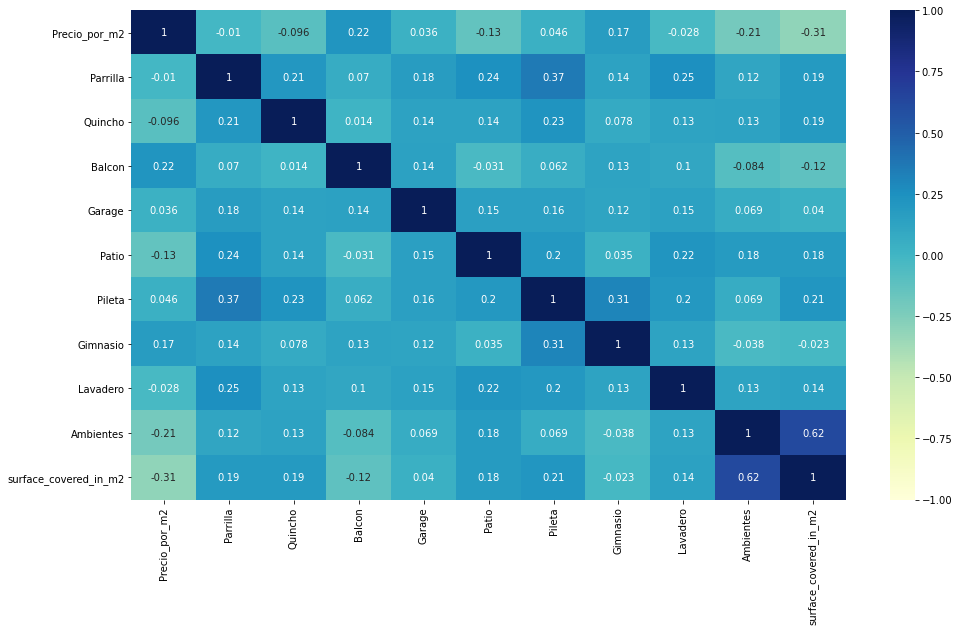

In [28]:
#Visualizamos la relación entre las variables tomando todo el país
features_ls = ['Parrilla',
    'Quincho',
    'Balcon',
    'Garage',
    'Patio',
    'Pileta',
    'Gimnasio',
    'Lavadero',
    'Tipo_Propiedad',
    'Ambientes',
    'surface_covered_in_m2']
plt.figure(figsize=(16,9))
sns.heatmap(data[['Precio_por_m2'] + features_ls].corr(), annot=True, vmin=-1, cmap='YlGnBu')

In [29]:
#Visualizamos la relación entre las variables tomando solamente AMBA
values=['Capital Federal','Bs.As. G.B.A. Zona Norte','Bs.As. G.B.A. Zona Sur']
data3 = data[data.Región.isin(values)]
data3.shape

(53625, 58)

<AxesSubplot:>

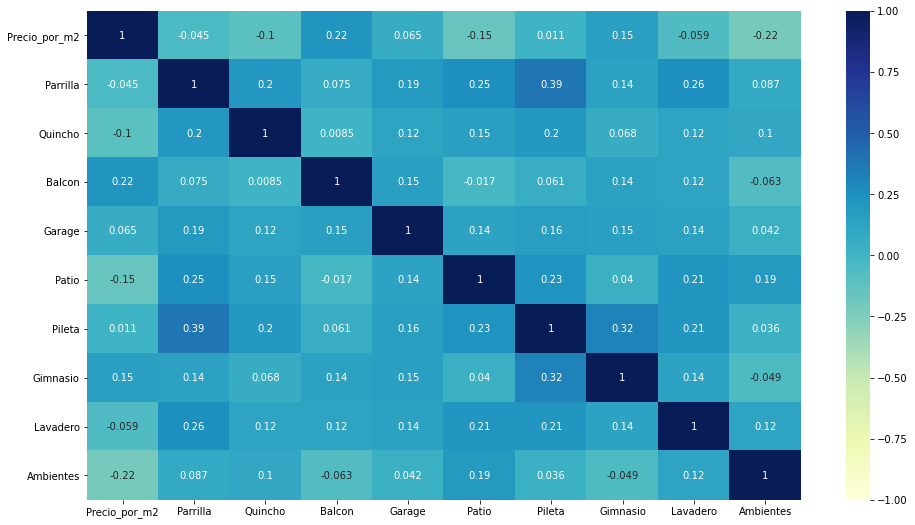

In [30]:
#Visualizamos la relación entre las variables tomando solamente AMBA
features_lr = ['Parrilla',
    'Quincho',
    'Balcon',
    'Garage',
    'Patio',
    'Pileta',
    'Gimnasio',
    'Lavadero',
    'Tipo_Propiedad',
    'Ambientes',
]

plt.figure(figsize=(16,9))
sns.heatmap(data3[['Precio_por_m2'] + features_lr].corr(), annot=True, vmin=-1, cmap='YlGnBu')

#### Conclusión: Podemos observar que las variables predictoras que pueden llegar a tener más peso en el modelo son:
#### TIPO DE PROPIEDAD, SUPERFICIE CUBIERTA, BALCON, PATIO, GIMNASIO, AMBIENTES

<a id="section_regarg"></a>

### Regresión lineal Argentina - SciKit Learn

[volver a TOC](#section_toc)


In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [32]:
# Creamos función para poder ir probando con distintos Features inicialmente

#Los pasos incluidos en la función son:
# 1. Seleccionar una clase de modelo
# 2. Elegir los hiperparámetros del modelo
# 3. Preparar los datos en una matriz de _features_ y un vector _target_
# 4. Separar los sets de entrenamiento y de testeo
# 5. Ajustar el modelo a los datos de entrenamiento¶
# 6. Predecir etiquetas para datos desconocidos
# 7. Evaluar la performance del modelo

# En la Función incluímos la regularización por StandardScaler luego de separar Train y Test

def train_test_error(feature_cols):
    X = data[feature_cols]
    y = data.Precio_por_m2
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_sc=pd.DataFrame(scaler.transform(X_train),index=X_train.index.values, columns=X_train.columns.values)
    linreg = LinearRegression()
    linreg.fit(X_train_sc, y_train)
    X_test_sc=scaler.transform(X_test)
    y_pred = linreg.predict(X_test_sc)
    
        
    print (feature_cols)
    print ("y_test sample: ",y_test.values[0:10])
    print ("y_pred sample: ",y_pred[0:10].astype(int))  
    print ('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print ('MSE:', metrics.mean_squared_error(y_test, y_pred))
    print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print ('R2:', metrics.r2_score(y_test, y_pred).round(2))
    print ()
    
    return

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82112 entries, 0 to 82111
Data columns (total 58 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Tipo_Propiedad                82112 non-null  object 
 1   Región                        82112 non-null  object 
 2   Precio                        82112 non-null  float64
 3   surface_total_in_m2           82112 non-null  float64
 4   surface_covered_in_m2         82112 non-null  float64
 5   Precio_por_m2                 82112 non-null  float64
 6   Garage                        82112 non-null  int64  
 7   Estado                        82112 non-null  int64  
 8   Pileta                        82112 non-null  int64  
 9   Balcon                        82112 non-null  int64  
 10  Gimnasio                      82112 non-null  int64  
 11  Quincho                       82112 non-null  int64  
 12  Parrilla                      82112 non-null  int64  
 13  P

In [34]:
#Probamos una regresión múltiple en todo el país con todas las Features
feature_cols = ['surface_total_in_m2', 'surface_covered_in_m2', 'Garage', 'Estado', 'Pileta', 'Balcon', 'Gimnasio', 'Quincho', 'Parrilla', 'Patio', 
                'Lavadero', 'Tipo_Propiedad_apartment', 'Tipo_Propiedad_house', 'Tipo_Propiedad_store', 'Bs.As. G.B.A. Zona Oeste', 'Bs.As. G.B.A. Zona Sur',
                'Buenos Aires Costa Atlántica', 'Buenos Aires Interior', 'Capital Federal', 'Catamarca', 'Chaco', 'Chubut', 'Corrientes', 'Córdoba',
                'Entre Ríos', 'Formosa', 'Jujuy', 'La Pampa', 'La Rioja', 'Mendoza', 'Misiones', 'Neuquén', 'Río Negro', 'Salta', 'San Juan', 'San Luis',
                'Santa Cruz', 'Santa Fe', 'Santiago Del Estero', 'Tierra Del Fuego', 'Tucumán', 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

a = train_test_error(feature_cols)
a

['surface_total_in_m2', 'surface_covered_in_m2', 'Garage', 'Estado', 'Pileta', 'Balcon', 'Gimnasio', 'Quincho', 'Parrilla', 'Patio', 'Lavadero', 'Tipo_Propiedad_apartment', 'Tipo_Propiedad_house', 'Tipo_Propiedad_store', 'Bs.As. G.B.A. Zona Oeste', 'Bs.As. G.B.A. Zona Sur', 'Buenos Aires Costa Atlántica', 'Buenos Aires Interior', 'Capital Federal', 'Catamarca', 'Chaco', 'Chubut', 'Corrientes', 'Córdoba', 'Entre Ríos', 'Formosa', 'Jujuy', 'La Pampa', 'La Rioja', 'Mendoza', 'Misiones', 'Neuquén', 'Río Negro', 'Salta', 'San Juan', 'San Luis', 'Santa Cruz', 'Santa Fe', 'Santiago Del Estero', 'Tierra Del Fuego', 'Tucumán', 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
y_test sample:  [1033.33333333 3731.27083333 1137.93103448 2785.71428571 1479.28994083
 1369.10694915 3000.         2156.8627451  2623.45679012 2471.83592593]
y_pred sample:  [1181 2633  937 2612 2571 1651 2481 1883 2729 1991]
MAE: 459.4532629616388
MSE: 353934.68831403274
RMSE: 594.9241029862824
R2: 0.49



In [35]:
#Probamos una regresión múltiple en todo el país sacando Features de amenities
feature_cols = ['surface_total_in_m2', 'surface_covered_in_m2', 'Tipo_Propiedad_apartment', 'Tipo_Propiedad_house', 'Tipo_Propiedad_store', 'Bs.As. G.B.A. Zona Oeste', 'Bs.As. G.B.A. Zona Sur',
                'Buenos Aires Costa Atlántica', 'Buenos Aires Interior', 'Capital Federal', 'Catamarca', 'Chaco', 'Chubut', 'Corrientes', 'Córdoba',
                'Entre Ríos', 'Formosa', 'Jujuy', 'La Pampa', 'La Rioja', 'Mendoza', 'Misiones', 'Neuquén', 'Río Negro', 'Salta', 'San Juan', 'San Luis',
                'Santa Cruz', 'Santa Fe', 'Santiago Del Estero', 'Tierra Del Fuego', 'Tucumán']

a = train_test_error(feature_cols)
a

['surface_total_in_m2', 'surface_covered_in_m2', 'Tipo_Propiedad_apartment', 'Tipo_Propiedad_house', 'Tipo_Propiedad_store', 'Bs.As. G.B.A. Zona Oeste', 'Bs.As. G.B.A. Zona Sur', 'Buenos Aires Costa Atlántica', 'Buenos Aires Interior', 'Capital Federal', 'Catamarca', 'Chaco', 'Chubut', 'Corrientes', 'Córdoba', 'Entre Ríos', 'Formosa', 'Jujuy', 'La Pampa', 'La Rioja', 'Mendoza', 'Misiones', 'Neuquén', 'Río Negro', 'Salta', 'San Juan', 'San Luis', 'Santa Cruz', 'Santa Fe', 'Santiago Del Estero', 'Tierra Del Fuego', 'Tucumán']
y_test sample:  [1033.33333333 3731.27083333 1137.93103448 2785.71428571 1479.28994083
 1369.10694915 3000.         2156.8627451  2623.45679012 2471.83592593]
y_pred sample:  [1288 2694  960 2686 2645 1737 2475 1651 2457 1891]
MAE: 463.36939097893213
MSE: 361538.3715751781
RMSE: 601.2806096783581
R2: 0.48



In [36]:
#Probamos una regresión múltiple en todo el país sacando las Features de Tipo de Propiedad
feature_cols = ['surface_total_in_m2', 'surface_covered_in_m2', 'Garage', 'Estado', 'Pileta', 'Balcon', 'Gimnasio', 'Quincho', 'Parrilla', 'Patio', 
                'Lavadero', 'Bs.As. G.B.A. Zona Oeste', 'Bs.As. G.B.A. Zona Sur',
                'Buenos Aires Costa Atlántica', 'Buenos Aires Interior', 'Capital Federal', 'Catamarca', 'Chaco', 'Chubut', 'Corrientes', 'Córdoba',
                'Entre Ríos', 'Formosa', 'Jujuy', 'La Pampa', 'La Rioja', 'Mendoza', 'Misiones', 'Neuquén', 'Río Negro', 'Salta', 'San Juan', 'San Luis',
                'Santa Cruz', 'Santa Fe', 'Santiago Del Estero', 'Tierra Del Fuego', 'Tucumán', 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

a = train_test_error(feature_cols)
a

['surface_total_in_m2', 'surface_covered_in_m2', 'Garage', 'Estado', 'Pileta', 'Balcon', 'Gimnasio', 'Quincho', 'Parrilla', 'Patio', 'Lavadero', 'Bs.As. G.B.A. Zona Oeste', 'Bs.As. G.B.A. Zona Sur', 'Buenos Aires Costa Atlántica', 'Buenos Aires Interior', 'Capital Federal', 'Catamarca', 'Chaco', 'Chubut', 'Corrientes', 'Córdoba', 'Entre Ríos', 'Formosa', 'Jujuy', 'La Pampa', 'La Rioja', 'Mendoza', 'Misiones', 'Neuquén', 'Río Negro', 'Salta', 'San Juan', 'San Luis', 'Santa Cruz', 'Santa Fe', 'Santiago Del Estero', 'Tierra Del Fuego', 'Tucumán', 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
y_test sample:  [1033.33333333 3731.27083333 1137.93103448 2785.71428571 1479.28994083
 1369.10694915 3000.         2156.8627451  2623.45679012 2471.83592593]
y_pred sample:  [1290 2535 1209 2643 2338 2066 2268 2059 2660 2021]
MAE: 497.92495294670874
MSE: 419857.06221165124
RMSE: 647.9637815585461
R2: 0.4



In [37]:
#Probamos una regresión múltiple en todo el país sacando las Features de Ubicación
feature_cols = ['surface_total_in_m2', 'surface_covered_in_m2', 'Garage', 'Estado', 'Pileta', 'Balcon', 'Gimnasio', 'Quincho', 'Parrilla', 'Patio', 
                'Lavadero', 'Tipo_Propiedad_apartment', 'Tipo_Propiedad_house', 'Tipo_Propiedad_store', 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

a = train_test_error(feature_cols)
a

['surface_total_in_m2', 'surface_covered_in_m2', 'Garage', 'Estado', 'Pileta', 'Balcon', 'Gimnasio', 'Quincho', 'Parrilla', 'Patio', 'Lavadero', 'Tipo_Propiedad_apartment', 'Tipo_Propiedad_house', 'Tipo_Propiedad_store', 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
y_test sample:  [1033.33333333 3731.27083333 1137.93103448 2785.71428571 1479.28994083
 1369.10694915 3000.         2156.8627451  2623.45679012 2471.83592593]
y_pred sample:  [1256 2227 1334 2371 2205 1339 2299 1724 2582 2355]
MAE: 547.2658171264335
MSE: 470678.2842841225
RMSE: 686.0599713466181
R2: 0.33



<a id="section_regcaba"></a>

### Regresión lineal CABA - SciKit Learn

[volver a TOC](#section_toc)


In [38]:
# Traemos data set para CABA
data2.info()
data2.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82112 entries, 0 to 82111
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tipo_Propiedad         82112 non-null  object 
 1   Región                 82112 non-null  object 
 2   Precio                 82112 non-null  float64
 3   surface_total_in_m2    82112 non-null  float64
 4   surface_covered_in_m2  82112 non-null  float64
 5   Precio_por_m2          82112 non-null  float64
 6   Garage                 82112 non-null  int64  
 7   Estado                 82112 non-null  int64  
 8   Pileta                 82112 non-null  int64  
 9   Balcon                 82112 non-null  int64  
 10  Gimnasio               82112 non-null  int64  
 11  Quincho                82112 non-null  int64  
 12  Parrilla               82112 non-null  int64  
 13  Patio                  82112 non-null  int64  
 14  Lavadero               82112 non-null  int64  
 15  Am

(82112, 19)

In [39]:
#Filtramos para CABA
data2 = data2[data2['Región'] == 'Capital Federal']
data2.info()
data2.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23422 entries, 0 to 82111
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tipo_Propiedad         23422 non-null  object 
 1   Región                 23422 non-null  object 
 2   Precio                 23422 non-null  float64
 3   surface_total_in_m2    23422 non-null  float64
 4   surface_covered_in_m2  23422 non-null  float64
 5   Precio_por_m2          23422 non-null  float64
 6   Garage                 23422 non-null  int64  
 7   Estado                 23422 non-null  int64  
 8   Pileta                 23422 non-null  int64  
 9   Balcon                 23422 non-null  int64  
 10  Gimnasio               23422 non-null  int64  
 11  Quincho                23422 non-null  int64  
 12  Parrilla               23422 non-null  int64  
 13  Patio                  23422 non-null  int64  
 14  Lavadero               23422 non-null  int64  
 15  Am

(23422, 19)

In [40]:
# Decidimos elegir los datos que tengan sin ningún tipo de inferencia de ambientes y distancia al subte
# Limpiamos totalmente distancia al subte
data2 = data2.dropna(subset=['dist_subte'], axis = 0) 
data2.info()
data2.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18934 entries, 0 to 82111
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tipo_Propiedad         18934 non-null  object 
 1   Región                 18934 non-null  object 
 2   Precio                 18934 non-null  float64
 3   surface_total_in_m2    18934 non-null  float64
 4   surface_covered_in_m2  18934 non-null  float64
 5   Precio_por_m2          18934 non-null  float64
 6   Garage                 18934 non-null  int64  
 7   Estado                 18934 non-null  int64  
 8   Pileta                 18934 non-null  int64  
 9   Balcon                 18934 non-null  int64  
 10  Gimnasio               18934 non-null  int64  
 11  Quincho                18934 non-null  int64  
 12  Parrilla               18934 non-null  int64  
 13  Patio                  18934 non-null  int64  
 14  Lavadero               18934 non-null  int64  
 15  Am

(18934, 19)

In [41]:
# Limpiamos ambientes
data2 = data2.dropna(subset=['Ambientes'], axis = 0) 
data2.info()
data2.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9111 entries, 9 to 82110
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tipo_Propiedad         9111 non-null   object 
 1   Región                 9111 non-null   object 
 2   Precio                 9111 non-null   float64
 3   surface_total_in_m2    9111 non-null   float64
 4   surface_covered_in_m2  9111 non-null   float64
 5   Precio_por_m2          9111 non-null   float64
 6   Garage                 9111 non-null   int64  
 7   Estado                 9111 non-null   int64  
 8   Pileta                 9111 non-null   int64  
 9   Balcon                 9111 non-null   int64  
 10  Gimnasio               9111 non-null   int64  
 11  Quincho                9111 non-null   int64  
 12  Parrilla               9111 non-null   int64  
 13  Patio                  9111 non-null   int64  
 14  Lavadero               9111 non-null   int64  
 15  Ame

(9111, 19)

In [42]:
#Creamos Dummies
Tipo_Propiedad_dummy = pd.get_dummies(data2['Tipo_Propiedad'], prefix= 'Tipo_Propiedad', drop_first=True)
data2 = pd.concat([data2, Tipo_Propiedad_dummy], axis=1)
Region_dummy = pd.get_dummies(data2['Barrio'], drop_first=True)
data2 = pd.concat([data2, Region_dummy], axis=1)
Ambientes_dummy = pd.get_dummies(data2['Ambientes'], drop_first=True)
data2 = pd.concat([data2, Ambientes_dummy], axis=1)

data2.shape

(9111, 78)

In [43]:
dataCABA = data2
dataCABA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9111 entries, 9 to 82110
Data columns (total 78 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tipo_Propiedad            9111 non-null   object 
 1   Región                    9111 non-null   object 
 2   Precio                    9111 non-null   float64
 3   surface_total_in_m2       9111 non-null   float64
 4   surface_covered_in_m2     9111 non-null   float64
 5   Precio_por_m2             9111 non-null   float64
 6   Garage                    9111 non-null   int64  
 7   Estado                    9111 non-null   int64  
 8   Pileta                    9111 non-null   int64  
 9   Balcon                    9111 non-null   int64  
 10  Gimnasio                  9111 non-null   int64  
 11  Quincho                   9111 non-null   int64  
 12  Parrilla                  9111 non-null   int64  
 13  Patio                     9111 non-null   int64  
 14  Lavader

<AxesSubplot:>

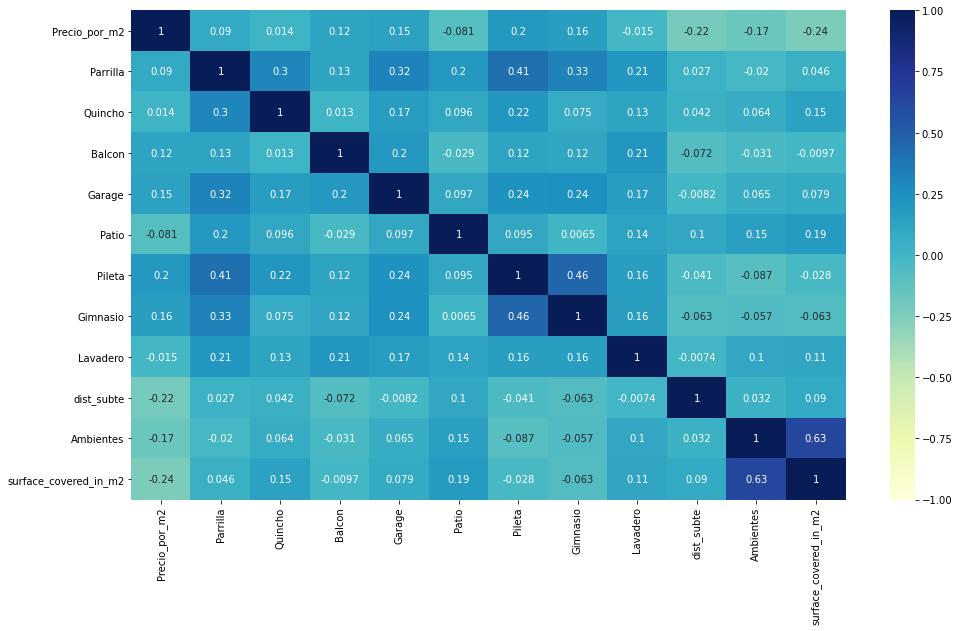

In [44]:
features_lr = ['Parrilla',
    'Quincho',
    'Balcon',
    'Garage',
    'Patio',
    'Pileta',
    'Gimnasio',
    'Lavadero',
    'Tipo_Propiedad',
    'dist_subte',
    'Ambientes',
    'surface_covered_in_m2']

plt.figure(figsize=(16,9))
sns.heatmap(data2[['Precio_por_m2'] + features_lr].corr(), annot=True, vmin=-1, cmap='YlGnBu')

In [45]:
#Agrego barrios CABA, OK
data2.Barrio.value_counts()

Caballito            946
Palermo              903
Belgrano             666
Recoleta             546
Flores               538
Balvanera            512
Almagro              452
Villa Crespo         439
Villa Urquiza        435
San Telmo            379
Floresta             210
Nuñez                210
Villa Luro           180
San Cristóbal        177
Saavedra             176
Barracas             166
San Nicolás          165
Villa Devoto         165
Monserrat            150
Villa del Parque     147
Liniers              138
Mataderos            131
Colegiales           117
Boedo                115
Parque Patricios      99
Parque Chacabuco      94
Coghlan               83
Chacarita             74
Paternal              72
Villa Lugano          68
Constitución          63
Villa Pueyrredón      63
Boca                  60
Retiro                50
Parque Avellaneda     46
Monte Castro          38
Villa Ortuzar         35
Agronomía             28
Villa Gral. Mitre     28
Versalles             26


In [46]:
#Probamos la regresión múltiple con CABA solamente

def train_test_error_CABA(feature_cols_CABA):
    X = data2[feature_cols_CABA]
    y = data2.Precio_por_m2
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_sc=pd.DataFrame(scaler.transform(X_train),index=X_train.index.values, columns=X_train.columns.values)
    linreg = LinearRegression()
    linreg.fit(X_train_sc, y_train)
    X_test_sc=scaler.transform(X_test)
    y_pred = linreg.predict(X_test_sc)
    
        
    print (feature_cols)
    print ("y_test sample: ",y_test.values[0:10])
    print ("y_pred sample: ",y_pred[0:10].astype(int))  
    print ('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print ('MSE:', metrics.mean_squared_error(y_test, y_pred))
    print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print ('R2:', metrics.r2_score(y_test, y_pred).round(2))
    print ()
    
    return

In [47]:
#Probamos una regresión múltiple con CABA y todas las Feauters
feature_cols_CABA = ['surface_total_in_m2', 'surface_covered_in_m2', 'Garage', 'Estado', 'Pileta', 'Balcon', 'Gimnasio', 'Quincho', 'Parrilla', 'Patio', 
                    'Lavadero', 'Tipo_Propiedad_apartment', 'Tipo_Propiedad_house', 'Tipo_Propiedad_store', "dist_subte",
                    2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 'Caballito', 'Palermo', 'Belgrano', 'Recoleta', 'Flores', 'Balvanera',
                     'Almagro', 'Villa Crespo','Villa Urquiza','San Telmo','Floresta', 'Nuñez', 'Villa Luro', 'San Cristóbal',
                     'Saavedra','Barracas', 'Villa Devoto','San Nicolás','Monserrat','Villa del Parque','Liniers','Mataderos',
                     'Colegiales','Boedo','Parque Patricios','Parque Chacabuco','Coghlan','Chacarita','Paternal','Villa Lugano',
                     'Constitución','Villa Pueyrredón','Boca','Retiro', 'Parque Avellaneda','Monte Castro' ,'Villa Ortuzar',
                     'Villa Gral. Mitre','Versalles','Villa Santa Rita','Villa Real','Vélez Sársfield','Nueva Pompeya',
                     'Parque Chas','Puerto Madero','Villa Riachuelo','Villa Soldati' ]

a = train_test_error_CABA(feature_cols_CABA)
a

['surface_total_in_m2', 'surface_covered_in_m2', 'Garage', 'Estado', 'Pileta', 'Balcon', 'Gimnasio', 'Quincho', 'Parrilla', 'Patio', 'Lavadero', 'Tipo_Propiedad_apartment', 'Tipo_Propiedad_house', 'Tipo_Propiedad_store', 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
y_test sample:  [4334.90566038 3870.73170732 2024.19354839 2826.08695652 1370.
 2050.         4065.57377049 2266.66666667 2075.         2112.5       ]
y_pred sample:  [2518 2862 2086 2917  572 2148 2655 2911 2169 2169]
MAE: 432.7860112678905
MSE: 305185.0371754214
RMSE: 552.4355502458377
R2: 0.4



<a id="section_stats"></a>

### Regresión lineal - StatsModel

[volver a TOC](#section_toc)


In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Importamos la api.
import statsmodels.api as sm

#Traemos data y escalamos
X = data2[(feature_cols_CABA)]
scaler = StandardScaler()
scaler.fit(X)
X=pd.DataFrame(scaler.transform(X),index=X.index.values, columns=X.columns.values)

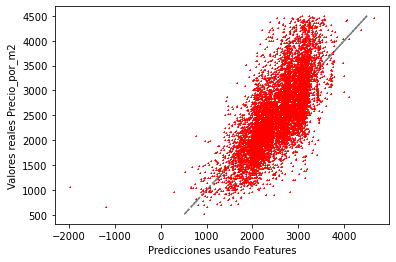

EMC: 250659.21371204098
                            OLS Regression Results                            
Dep. Variable:          Precio_por_m2   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     130.8
Date:                Wed, 05 May 2021   Prob (F-statistic):               0.00
Time:                        11:33:02   Log-Likelihood:                -69561.
No. Observations:                9111   AIC:                         1.393e+05
Df Residuals:                    9039   BIC:                         1.398e+05
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------


In [49]:
y = data2.Precio_por_m2
# Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Graficamos los resultados
plt.plot(y,y, '-.', c='grey')
#plt.figure(figsize=(20,10))
plt.scatter(predictions, y, s=1, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones usando Features")
plt.ylabel("Valores reales Precio_por_m2")
plt.show()

# Imprimimos el MSE y un resumen del modelo
print ("EMC:", mean_squared_error(y, predictions))
print (model.summary())

Se pueden ver variables con PValue por encima de 0,05 entendiendo así que no nos brindas significancia al modelo. Luego al realizar la regularización por Lasso veremos que variables nos indica posible eliminar.

In [50]:
X = data2[feature_cols_CABA]

<a id="section_regu"></a>

### Regularización Ridge y Lasso

[volver a TOC](#section_toc)


In [51]:
#Separamos Train y Test
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True, random_state=10, test_size= 0.33)

In [52]:
X_train.shape

(6104, 71)

In [53]:
y_test.shape

(3007,)

In [54]:
#Escalamos los datos de entrenamiento
scaler = StandardScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train),index=X_train.index.values, columns=X_train.columns.values)

In [55]:
#Fiteamos
baseline = sm.OLS(y_train, sm.add_constant(X_train)).fit()
baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Precio_por_m2   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     85.64
Date:                Wed, 05 May 2021   Prob (F-statistic):               0.00
Time:                        11:33:03   Log-Likelihood:                -46613.
No. Observations:                6104   AIC:                         9.337e+04
Df Residuals:                    6032   BIC:                         9.385e+04
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     2546.8533      6.457    394.461      0.000    2534.196    2559.510
surface_total_in_m2        270.6603     19.410     13.944      0.000     232.610     308.711
surface_covered_in_m2     -364.7258     19.576    -18.631      0.000    -403.102    -326.350
Garage                      49.2813      7.342      6.712      0.000      34.888      63.675
Estado                      38.9517      6.710      5.805      0.000      25.797      52.106
Pileta                      66.7771      8.083      8.262      0.000      50.932      82.622
Balcon                      20.5684      6.974      2.949      0.003       6.898      34.239
Gimnasio                    41.8196      7.994      5.231      0.000      26.148      57.491
Quincho                     19.6574      7.047      2.790      0.005       5.843      33.472
Parrilla                     7.0298      8.010      0.878      0.380      -8.672      22.732
Patio                       -7.7233      7.008     -1.102      0.270     -21.461       6.014
Lavadero                   -21.1884      7.057     -3.003      0.003     -35.022      -7.354
Tipo_Propiedad_apartment   104.4651      9.041     11.555      0.000      86.742     122.188
Tipo_Propiedad_house        -7.4241      8.807     -0.843      0.399     -24.690       9.842
Tipo_Propiedad_store        -4.0855      6.774     -0.603      0.546     -17.365       9.194
dist_subte                 -26.3528     16.463     -1.601      0.109     -58.626       5.921
2.0                         -7.2106     12.038     -0.599      0.549     -30.810      16.388
3.0                        -11.0280     12.557     -0.878      0.380     -35.644      13.588
4.0                         14.1515     12.267      1.154      0.249      -9.897      38.200
5.0                        -11.6611      9.143     -1.275      0.202     -29.584       6.262
6.0                         -4.9564      7.901     -0.627      0.530     -20.445      10.533
7.0                         -9.7725      7.204     -1.356      0.175     -23.895       4.350
8.0                          0.4121      6.704      0.061      0.951     -12.730      13.554
9.0                        -14.1759      6.576     -2.156      0.031     -27.067      -1.285
10.0                        -6.7506      6.630     -1.018      0.309     -19.748       6.247
Caballito                  121.2046     34.177      3.546      0.000      54.205     188.204
Palermo                    233.2313     33.352      6.993      0.000     167.850     298.613
Belgrano                   213.8879     29.375      7.281      0.000     156.303     271.473
Recoleta                   157.4072     27.526      5.718      0.000     103.446     211.368
Flores                     -45.4286     27.184     -1.671      0.095     -98.719       7.862
Balvanera     

In [56]:
coef_df = pd.DataFrame(baseline.params)
coef_df["beta"] = coef_df[0]
coef_df.drop(columns=0, inplace=True)
coef_df

,beta
const,2546.853330
surface_total_in_m2,270.660252
surface_covered_in_m2,-364.725761
Garage,49.281278
Estado,38.951741
...,...
Nueva Pompeya,-33.577683
Parque Chas,15.010224
Puerto Madero,55.584193
Villa Riachuelo,-4.932619


### Regresion Lasso de CABA

In [57]:
kf = KFold(shuffle=True, random_state=10)

In [58]:
model_skl_LassoCV = linear_model.LassoCV(alphas=np.linspace(0.0001,0.01, 100), cv=kf, normalize=True)
model_skl_LassoCV.fit(X_train, y_train)
print("Alpha óptimo:", model_skl_LassoCV.alpha_)
print("R2 Lasso de entrenamiento:",model_skl_LassoCV.score(X_train, y_train).round(3))


Alpha óptimo: 0.01
R2 Lasso de entrenamiento: 0.502


In [59]:
betas = pd.DataFrame(data= model_skl_LassoCV.coef_ , index=X_train.columns, columns=['Betas'])

betas_0_mask = betas.Betas == 0
print("Variables igualadas a 0 por Lasso:", betas_0_mask.sum())

Variables igualadas a 0 por Lasso: 2


In [60]:
betas_0_mask[betas_0_mask == True] # Borrarlas

8.0        True
Almagro    True
Name: Betas, dtype: bool

In [61]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6104, 71)
(6104,)
(3007, 71)
(3007,)


### Ridge de CABA

In [62]:
model_skl_RidgeCV = linear_model.RidgeCV(alphas=np.linspace(0.001,0.1, 100), cv=kf, normalize=True)
model_skl_RidgeCV.fit(X_train, y_train)
print("Alpha óptimo:", model_skl_RidgeCV.alpha_)
print("R2 Ridge de entrenamiento:",model_skl_RidgeCV.score(X_train, y_train).round(3))

Alpha óptimo: 0.1
R2 Ridge de entrenamiento: 0.49


<a id="section_muestra"></a>

### Analisis de muestra de 100 propiedades

[volver a TOC](#section_toc)

In [63]:
#Escalamos y Fiteamos para luego seleccionar 100 propiedades
X_test=pd.DataFrame(scaler.transform(X_test),index=X_test.index.values, columns=X_test.columns.values)
prediction_sm = baseline.predict(sm.add_constant(X_test))
print ('R2 Statmodels OLS:', r2_score(y_test, prediction_sm).round(3))

R2 Statmodels OLS: 0.509


In [64]:
#Vemos 5 para luego filtrar
predicciones = prediction_sm
data2.reset_index(inplace= True)
data2.drop(columns= ['index'], inplace = True)
data2.head(5)

,Tipo_Propiedad,Región,Precio,surface_total_in_m2,surface_covered_in_m2,Precio_por_m2,Garage,Estado,Pileta,Balcon,...,Vélez Sársfield,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
0,PH,Capital Federal,239000.0,140.0,98.0,2438.775510,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,apartment,Capital Federal,110000.0,50.0,50.0,2200.000000,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,apartment,Capital Federal,173000.0,50.0,50.0,3460.000000,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,apartment,Capital Federal,178000.0,55.0,55.0,3236.363636,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,apartment,Capital Federal,129000.0,80.0,80.0,1612.500000,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [65]:
data_sample = data2
data_sample['prediccion'] = predicciones

In [66]:
#Vemos las 100 seleccionadas
predicts_not_null = data_sample[data_sample.prediccion.notnull()]
data_predict = predicts_not_null.sample(100, random_state=1)
data_predict

,Tipo_Propiedad,Región,Precio,surface_total_in_m2,surface_covered_in_m2,Precio_por_m2,Garage,Estado,Pileta,Balcon,...,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,prediccion
5342,apartment,Capital Federal,85000.0,37.0,37.0,2297.297297,1,0,1,1,...,1,0,0,0,0,0,0,0,0,2679.012122
4243,apartment,Capital Federal,125000.0,64.0,44.0,2840.909091,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2246.738501
8289,house,Capital Federal,270000.0,400.0,220.0,1227.272727,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2006.746392
6508,apartment,Capital Federal,95000.0,50.0,46.0,2065.217391,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2562.584460
3350,apartment,Capital Federal,66000.0,28.0,28.0,2357.142857,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1825.905554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4632,house,Capital Federal,280000.0,193.0,193.0,1450.777202,1,0,0,0,...,0,0,1,0,0,0,0,0,0,2625.223961
5317,apartment,Capital Federal,110000.0,54.0,54.0,2037.037037,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2363.033258
8008,apartment,Capital Federal,188000.0,81.0,81.0,2320.987654,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2891.926112
5710,apartment,Capital Federal,160000.0,80.0,80.0,2000.000000,1,0,0,1,...,1,0,0,0,0,0,0,0,0,2821.974902


In [67]:
#Agregamos columna con la diferencia entre el precio por metro cuadrado del valor real y el predicho
data_predict['diferencia'] = data_predict['prediccion'] - data_predict['Precio_por_m2']
data_predict

,Tipo_Propiedad,Región,Precio,surface_total_in_m2,surface_covered_in_m2,Precio_por_m2,Garage,Estado,Pileta,Balcon,...,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,prediccion,diferencia
5342,apartment,Capital Federal,85000.0,37.0,37.0,2297.297297,1,0,1,1,...,0,0,0,0,0,0,0,0,2679.012122,381.714825
4243,apartment,Capital Federal,125000.0,64.0,44.0,2840.909091,0,0,0,0,...,0,0,0,0,0,0,0,0,2246.738501,-594.170590
8289,house,Capital Federal,270000.0,400.0,220.0,1227.272727,0,0,0,0,...,0,0,0,1,0,0,0,0,2006.746392,779.473665
6508,apartment,Capital Federal,95000.0,50.0,46.0,2065.217391,0,0,0,0,...,0,0,0,0,0,0,0,0,2562.584460,497.367068
3350,apartment,Capital Federal,66000.0,28.0,28.0,2357.142857,0,0,0,0,...,0,0,0,0,0,0,0,0,1825.905554,-531.237303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4632,house,Capital Federal,280000.0,193.0,193.0,1450.777202,1,0,0,0,...,0,1,0,0,0,0,0,0,2625.223961,1174.446759
5317,apartment,Capital Federal,110000.0,54.0,54.0,2037.037037,0,0,0,0,...,1,0,0,0,0,0,0,0,2363.033258,325.996221
8008,apartment,Capital Federal,188000.0,81.0,81.0,2320.987654,0,0,0,0,...,0,1,0,0,0,0,0,0,2891.926112,570.938458
5710,apartment,Capital Federal,160000.0,80.0,80.0,2000.000000,1,0,0,1,...,0,0,0,0,0,0,0,0,2821.974902,821.974902


Text(0.5, 0, 'Y_test')

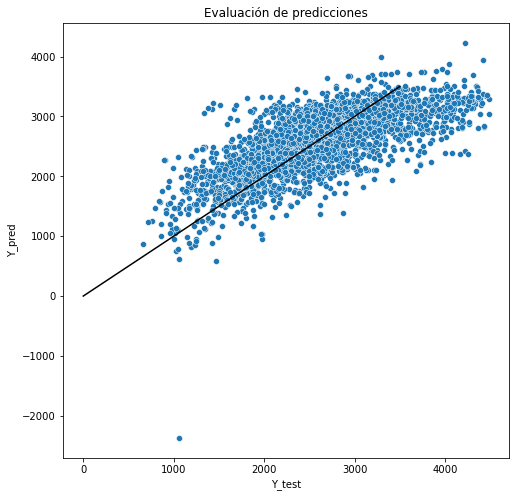

In [68]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(8,8))
sns.scatterplot(y_test,prediction_sm)
sns.lineplot([0,3500],[0,3500],color='black')
plt.title("Evaluación de predicciones")
plt.ylabel("Y_pred")
plt.xlabel("Y_test")

Text(0.5, 0, 'Precios por m2 reales')

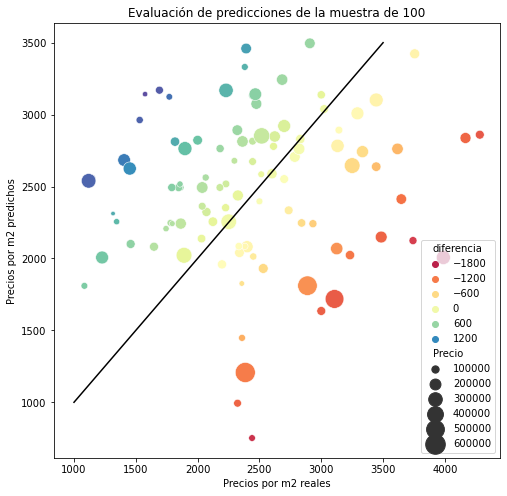

In [69]:
#Graficamos los valores reales y predichos de precio por metros cuadrados de las muestra de 100 propiedades para detectar oportunidades
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(8,8))
sns.scatterplot(data=data_predict, x= 'Precio_por_m2', y= 'prediccion', hue= 'diferencia', palette= 'Spectral', size= 'Precio', sizes=(20, 400))
sns.lineplot([1000,3500],[1000,3500],color='black')
plt.title("Evaluación de predicciones de la muestra de 100")
plt.ylabel("Precios por m2 predichos")
plt.xlabel("Precios por m2 reales")

In [70]:
#Detectamos cuantos valores sobrevaluados y subvaluados hay en la muestra
subvaluados = data_predict['diferencia'] > 0
sobrevaluados = data_predict['diferencia'] < 0
print("Hay", subvaluados.sum(),"subvaluados y ",sobrevaluados.sum(),"sobrevaluados en la muestra")

Hay 59 subvaluados y  41 sobrevaluados en la muestra


In [71]:
#Obtenemos las 5 mejores oportunidades en cuanto a la diferencia del precio por metro cuadrado del valor real y el predicho 
mejores_oportunidades = data_predict.sort_values('diferencia',ascending=False)
mejores_oportunidades.head(5)

,Tipo_Propiedad,Región,Precio,surface_total_in_m2,surface_covered_in_m2,Precio_por_m2,Garage,Estado,Pileta,Balcon,...,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,prediccion,diferencia
5611,PH,Capital Federal,63000.0,40.0,40.0,1575.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,3142.376442,1567.376442
8419,apartment,Capital Federal,115000.0,84.0,68.0,1691.176471,0,0,0,0,...,1,0,0,0,0,0,0,0,3169.738177,1478.561706
1731,apartment,Capital Federal,98000.0,64.0,64.0,1531.250000,0,0,0,0,...,1,0,0,0,0,0,0,0,2962.450982,1431.200982
9018,house,Capital Federal,340000.0,304.0,304.0,1118.421053,0,0,0,0,...,0,0,0,1,0,0,0,0,2539.579594,1421.158542
631,PH,Capital Federal,86000.0,85.0,75.0,1146.666667,0,0,0,0,...,0,1,0,0,0,0,0,0,2559.016445,1412.349778
